In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, FunctionTransformer, label_binarize, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
data_file = pd.read_csv('loan.csv',index_col=[0])
data_file.head()

c:\users\hrafiq\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
(data_file['emp_title'] == 'Ryder').sum()

1

In [4]:
data_file.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 1077501 to 87023
Data columns (total 110 columns):
member_id                         int64
loan_amnt                         int64
funded_amnt                       int64
funded_amnt_inv                   float64
term                              object
int_rate                          object
installment                       float64
grade                             object
sub_grade                         object
emp_title                         object
emp_length                        object
home_ownership                    object
annual_inc                        float64
verification_status               object
issue_d                           object
loan_status                       object
pymnt_plan                        object
url                               object
desc                              object
purpose                           object
title                             object
zip_code               

In [5]:
#Temp file
data_temp = data_file

In [6]:
#Remove 'Current' accounts
print(data_temp.loan_status.unique())
(data_temp.loan_status == 'Current').sum()

['Fully Paid' 'Charged Off' 'Current']


1140

In [7]:
data_temp = data_temp.drop(data_temp[data_temp.loan_status == 'Current'].index,axis=0)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 1077501 to 87023
Columns: 110 entries, member_id to total_il_high_credit_limit
dtypes: float64(74), int64(12), object(24)
memory usage: 32.7+ MB


In [8]:
#Drop null columns
data_temp = data_temp.dropna(axis=1, how='all')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 1077501 to 87023
Data columns (total 55 columns):
member_id                     38577 non-null int64
loan_amnt                     38577 non-null int64
funded_amnt                   38577 non-null int64
funded_amnt_inv               38577 non-null float64
term                          38577 non-null object
int_rate                      38577 non-null object
installment                   38577 non-null float64
grade                         38577 non-null object
sub_grade                     38577 non-null object
emp_title                     36191 non-null object
emp_length                    37544 non-null object
home_ownership                38577 non-null object
annual_inc                    38577 non-null float64
verification_status           38577 non-null object
issue_d                       38577 non-null object
loan_status                   38577 non-null object
pymnt_plan                    38577 non-null object
u

In [9]:
#Read unique values
data_temp['pub_rec'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [10]:
#Prepare set of extra set of columns which should be removed
#Also remove columns which give hint that loan was given -> We only want to keep columns which get filled before loan process
remove_cols = ['member_id','url','mths_since_last_delinq','desc','recoveries','collection_recovery_fee',
               'total_rec_prncp','total_pymnt','total_pymnt_inv','last_pymnt_amnt','funded_amnt_inv','funded_amnt',
               'installment','total_rec_int','int_rate','total_rec_late_fee','revol_util','revol_bal',
               'total_acc','open_acc','term','chargeoff_within_12_mths','collections_12_mths_ex_med','verification_status',
               'pymnt_plan','mths_since_last_record','last_credit_pull_d','policy_code','acc_now_delinq','pub_rec_bankruptcies',
               'delinq_amnt','delinq_2yrs','last_pymnt_d','issue_d']

for c_ in remove_cols:
    try:
        data_temp.drop(c_,axis=1,inplace=True)
    except:
        continue

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 1077501 to 87023
Data columns (total 21 columns):
loan_amnt              38577 non-null int64
grade                  38577 non-null object
sub_grade              38577 non-null object
emp_title              36191 non-null object
emp_length             37544 non-null object
home_ownership         38577 non-null object
annual_inc             38577 non-null float64
loan_status            38577 non-null object
purpose                38577 non-null object
title                  38566 non-null object
zip_code               38577 non-null object
addr_state             38577 non-null object
dti                    38577 non-null float64
earliest_cr_line       38577 non-null object
inq_last_6mths         38577 non-null int64
pub_rec                38577 non-null int64
initial_list_status    38577 non-null object
out_prncp              38577 non-null float64
out_prncp_inv          38577 non-null float64
application_type       38577 

In [11]:
data_temp.head()

,loan_amnt,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,loan_status,purpose,title,...,addr_state,dti,earliest_cr_line,inq_last_6mths,pub_rec,initial_list_status,out_prncp,out_prncp_inv,application_type,tax_liens
id,,,,,,,,,,,,,,,,,,,,,
1077501,5000,B,B2,NaN,10+ years,RENT,24000.0,Fully Paid,credit_card,Computer,...,AZ,27.65,Jan-85,1,0,f,0.0,0.0,INDIVIDUAL,0.0
1077430,2500,C,C4,Ryder,< 1 year,RENT,30000.0,Charged Off,car,bike,...,GA,1.00,Apr-99,5,0,f,0.0,0.0,INDIVIDUAL,0.0
1077175,2400,C,C5,NaN,10+ years,RENT,12252.0,Fully Paid,small_business,real estate business,...,IL,8.72,1-Nov,2,0,f,0.0,0.0,INDIVIDUAL,0.0
1076863,10000,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Fully Paid,other,personel,...,CA,20.00,Feb-96,1,0,f,0.0,0.0,INDIVIDUAL,0.0
1075269,5000,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Fully Paid,wedding,My wedding loan I promise to pay back,...,AZ,11.20,4-Nov,3,0,f,0.0,0.0,INDIVIDUAL,0.0


In [12]:
#Clean texts on textual columns
def clean_col_text(row):
    t_ = row.lower()

#Run on all textual columns
for c_ in data_temp.columns:
    if data_temp[c_].dtype == 'object':
        print('Column {}'.format(c_.upper()))
        data_temp[c_] = data_temp[c_].apply(lambda x: str(x).lower())
        
data_temp.head()

Column GRADE
Column SUB_GRADE
Column EMP_TITLE
Column EMP_LENGTH
Column HOME_OWNERSHIP
Column LOAN_STATUS
Column PURPOSE
Column TITLE
Column ZIP_CODE
Column ADDR_STATE
Column EARLIEST_CR_LINE
Column INITIAL_LIST_STATUS
Column APPLICATION_TYPE


,loan_amnt,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,loan_status,purpose,title,...,addr_state,dti,earliest_cr_line,inq_last_6mths,pub_rec,initial_list_status,out_prncp,out_prncp_inv,application_type,tax_liens
id,,,,,,,,,,,,,,,,,,,,,
1077501,5000,b,b2,nan,10+ years,rent,24000.0,fully paid,credit_card,computer,...,az,27.65,jan-85,1,0,f,0.0,0.0,individual,0.0
1077430,2500,c,c4,ryder,< 1 year,rent,30000.0,charged off,car,bike,...,ga,1.00,apr-99,5,0,f,0.0,0.0,individual,0.0
1077175,2400,c,c5,nan,10+ years,rent,12252.0,fully paid,small_business,real estate business,...,il,8.72,1-nov,2,0,f,0.0,0.0,individual,0.0
1076863,10000,c,c1,air resources board,10+ years,rent,49200.0,fully paid,other,personel,...,ca,20.00,feb-96,1,0,f,0.0,0.0,individual,0.0
1075269,5000,a,a4,veolia transportaton,3 years,rent,36000.0,fully paid,wedding,my wedding loan i promise to pay back,...,az,11.20,4-nov,3,0,f,0.0,0.0,individual,0.0


In [13]:
#Get unique value of non numeric columns
for c_ in data_temp.columns:
    if data_temp[c_].dtype == 'object':
        n_ = len(data_temp[c_].unique())
        print("Column {} has {} values".format(c_.upper(), n_))
        
        #Drop single valued and >1000 columns
        if n_ == 1:
            data_temp.drop(c_, axis=1, inplace=True)
        elif n_ > 1000:
            data_temp.drop(c_, axis=1, inplace=True)
            
data_temp.info()

Column GRADE has 7 values
Column SUB_GRADE has 35 values
Column EMP_TITLE has 26704 values
Column EMP_LENGTH has 12 values
Column HOME_OWNERSHIP has 5 values
Column LOAN_STATUS has 2 values
Column PURPOSE has 14 values
Column TITLE has 17408 values
Column ZIP_CODE has 822 values
Column ADDR_STATE has 50 values
Column EARLIEST_CR_LINE has 524 values
Column INITIAL_LIST_STATUS has 1 values
Column APPLICATION_TYPE has 1 values
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 1077501 to 87023
Data columns (total 17 columns):
loan_amnt           38577 non-null int64
grade               38577 non-null object
sub_grade           38577 non-null object
emp_length          38577 non-null object
home_ownership      38577 non-null object
annual_inc          38577 non-null float64
loan_status         38577 non-null object
purpose             38577 non-null object
zip_code            38577 non-null object
addr_state          38577 non-null object
dti                 38577 non-null fl

In [14]:
# #Create some new calculated columns
# data_temp['new_ratio_loan_salary'] = data_temp['loan_amnt'] / data_temp['annual_inc']

# data_temp.describe()

In [15]:
#Remove columns with all values = 0
for c_ in data_temp.columns:
    if not data_temp[c_].dtype == 'object':
        if data_temp[c_].max() - data_temp[c_].min() == 0:
            print("Dropping column {}".format(c_.upper()))
            data_temp.drop(c_, axis=1, inplace=True)
            
data_temp.info()

Dropping column OUT_PRNCP
Dropping column OUT_PRNCP_INV
Dropping column TAX_LIENS
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 1077501 to 87023
Data columns (total 14 columns):
loan_amnt           38577 non-null int64
grade               38577 non-null object
sub_grade           38577 non-null object
emp_length          38577 non-null object
home_ownership      38577 non-null object
annual_inc          38577 non-null float64
loan_status         38577 non-null object
purpose             38577 non-null object
zip_code            38577 non-null object
addr_state          38577 non-null object
dti                 38577 non-null float64
earliest_cr_line    38577 non-null object
inq_last_6mths      38577 non-null int64
pub_rec             38577 non-null int64
dtypes: float64(2), int64(3), object(9)
memory usage: 4.4+ MB


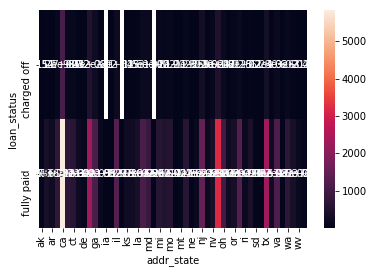

In [16]:
#Pivot table and Heatmap( Catego Vs Catego plot ) - State Vs Loan status
d_t = data_temp.pivot_table(columns='addr_state',index='loan_status',values='loan_amnt',aggfunc='count')
#print(d_t)

sns.heatmap(d_t, annot=True)
plt.show()

In [17]:
data_temp.corr('pearson')

,loan_amnt,annual_inc,dti,inq_last_6mths,pub_rec
loan_amnt,1.000000,0.268999,0.062436,0.012940,-0.049997
annual_inc,0.268999,1.000000,-0.121530,0.035465,-0.017864
dti,0.062436,-0.121530,1.000000,0.002178,-0.004742
inq_last_6mths,0.012940,0.035465,0.002178,1.000000,0.023726
pub_rec,-0.049997,-0.017864,-0.004742,0.023726,1.000000


In [18]:
# #Facet1
# g = sns.FacetGrid(data_temp, col="loan_status")
# g = g.map(plt.hist, "new_ratio_loan_salary")
# plt.show()

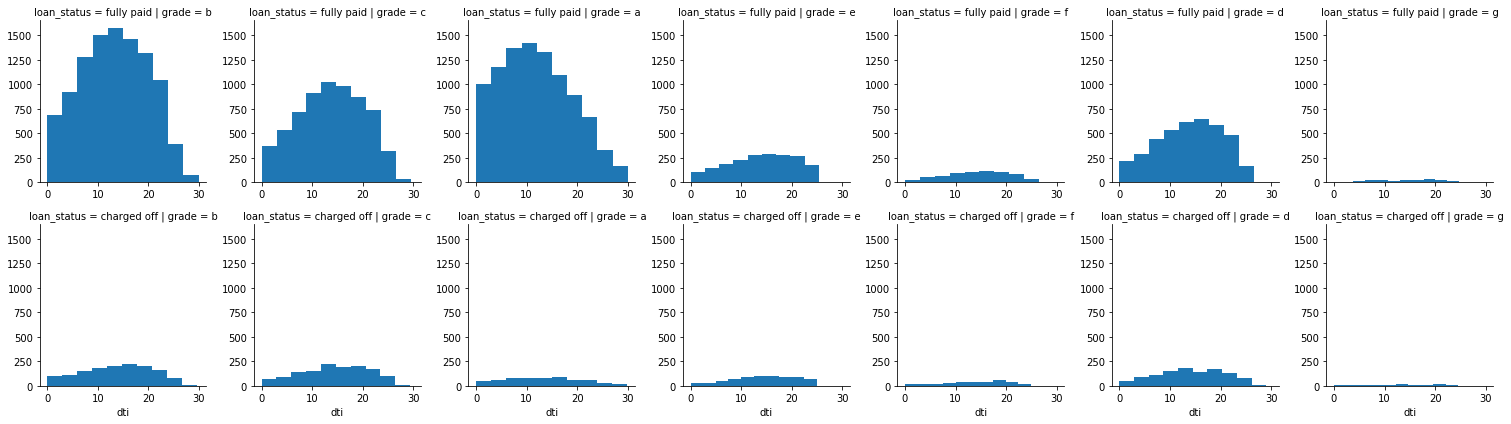

In [19]:
#Facet2
g = sns.FacetGrid(data_temp, col="grade",  row="loan_status")
g = g.map(plt.hist, "dti")
plt.show()

In [20]:
#Convert output column to classes(0,1,2,3)
data_temp['loan_status'] = data_temp['loan_status'].astype('category').cat.codes

#One hot all categorical attribs
#data_temp = pd.get_dummies(data_temp)
#data_temp.info()

In [21]:
#Prepare train and output columns
df_train_x = data_temp.drop(['loan_status'],axis=1)
df_train_y = data_temp['loan_status']

In [22]:
#Split dataset -> Split 10 times and choose the one with best P values( Significance test )
p_res = {}
t_res = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(df_train_x, df_train_y, test_size=0.2, random_state=i,stratify=df_train_y)

    #Run Significance Tests on both the distributions( Train and Test ) for all numerical attributes
    p_res = {}
    for c_ in X_train.columns:
        if not X_train[c_].dtype == 'object':
            try:
                _, a = scipy.stats.ks_2samp(X_train[c_].values,X_test[c_].values)
                #print('P-value for column {} is {}'.format(c_.upper(), a))
                p_res['Random'] = i
                p_res[c_] = a
            except:
                p_res['Random'] = i
                p_res[c_] = 'Error'
    t_res.append(p_res)

p_df = pd.DataFrame(t_res)
p_df

,Random,annual_inc,dti,inq_last_6mths,loan_amnt,pub_rec
0,0,0.558342,0.896108,0.948509,0.633736,1.000000
1,1,0.550245,0.092513,0.999999,0.777719,0.999201
2,2,0.424372,0.246819,0.693523,0.888957,1.000000
3,3,0.132435,0.190564,0.999536,0.925830,1.000000
4,4,0.630871,0.269552,0.978727,0.221695,1.000000
5,5,0.698811,0.621774,0.988226,0.884059,0.965985
6,6,0.991425,0.032893,1.000000,0.370564,1.000000
7,7,0.167003,0.081089,0.746005,0.956312,0.999999
8,8,0.436905,0.583043,0.999998,0.977834,1.000000
9,9,0.715394,0.184833,0.948509,0.865033,0.999995


In [23]:
#Use the best split value from above after manual inspection
X_train, X_test, y_train, y_test = train_test_split(df_train_x, df_train_y, test_size=0.2, random_state=4,stratify=df_train_y)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30861 entries, 486172 to 601084
Data columns (total 13 columns):
loan_amnt           30861 non-null int64
grade               30861 non-null object
sub_grade           30861 non-null object
emp_length          30861 non-null object
home_ownership      30861 non-null object
annual_inc          30861 non-null float64
purpose             30861 non-null object
zip_code            30861 non-null object
addr_state          30861 non-null object
dti                 30861 non-null float64
earliest_cr_line    30861 non-null object
inq_last_6mths      30861 non-null int64
pub_rec             30861 non-null int64
dtypes: float64(2), int64(3), object(8)
memory usage: 3.3+ MB


In [25]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7716 entries, 413920 to 718329
Data columns (total 13 columns):
loan_amnt           7716 non-null int64
grade               7716 non-null object
sub_grade           7716 non-null object
emp_length          7716 non-null object
home_ownership      7716 non-null object
annual_inc          7716 non-null float64
purpose             7716 non-null object
zip_code            7716 non-null object
addr_state          7716 non-null object
dti                 7716 non-null float64
earliest_cr_line    7716 non-null object
inq_last_6mths      7716 non-null int64
pub_rec             7716 non-null int64
dtypes: float64(2), int64(3), object(8)
memory usage: 843.9+ KB


In [26]:
#Get unique value of non numeric columns
print("Traing Set")
for c_ in X_train.columns:
    if X_train[c_].dtype == 'object':
        n_ = len(X_train[c_].unique())
        print("Column {} has {} values".format(c_.upper(), n_))
        
print("Test Set")
for c_ in X_test.columns:
    if X_test[c_].dtype == 'object':
        n_ = len(X_test[c_].unique())
        print("Column {} has {} values".format(c_.upper(), n_))

Traing Set
Column GRADE has 7 values
Column SUB_GRADE has 35 values
Column EMP_LENGTH has 12 values
Column HOME_OWNERSHIP has 5 values
Column PURPOSE has 14 values
Column ZIP_CODE has 814 values
Column ADDR_STATE has 50 values
Column EARLIEST_CR_LINE has 518 values
Test Set
Column GRADE has 7 values
Column SUB_GRADE has 35 values
Column EMP_LENGTH has 12 values
Column HOME_OWNERSHIP has 4 values
Column PURPOSE has 14 values
Column ZIP_CODE has 703 values
Column ADDR_STATE has 48 values
Column EARLIEST_CR_LINE has 442 values


In [33]:
##https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines
#Create transformation and model pipeline

#Create Pipeline function to oneHot a Categorical column
# class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
#     def __init__(self, sparse_output=False):
#         self.sparse_output = sparse_output
        
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         enc = LabelBinarizer(sparse_output=self.sparse_output)
#         return enc.fit_transform(X)

#Transformer functions
def select_col_df(df, cols, iscatego):
    if iscatego == True:
        return df[cols]
    else:
        return df[[cols]]

def calc_ratio_loan_income(df):
    df['new_ratio_loan_salary'] = df['loan_amnt'] / df['annual_inc']
    return(df[['new_ratio_loan_salary']])

#1. Hash convert categorical columns
col_pipe = {}
for c_ in X_train.columns:
    if X_train[c_].dtype == 'object':
#         col_pipe[c_] = Pipeline([
#                                 ('column_selector', CatColSelector(key=c_)),
#                                 ('column_oh', CustomLabelBinarizer())
#                             ])
        
        col_pipe[c_] = Pipeline([
                                    ('col_sel', FunctionTransformer(select_col_df,kw_args={'cols': c_, 'iscatego': True},
                                                                    validate=False)),
                                    ('col_hash', FeatureHasher(n_features=10,input_type='string'))
                                ])
        
#2. Also add numerical columns into pipeline
for c_ in X_train.columns:
    if not X_train[c_].dtype == 'object':
        col_pipe[c_] = Pipeline([
                                ('col_sel', FunctionTransformer(select_col_df,kw_args={'cols': c_, 'iscatego': False},
                                                                validate=False)),
                                ('std_scaler', StandardScaler())
                            ])

#3. Create a few new columns: "new_ratio_loan_salary"
col_pipe['new_ratio_loan_salary'] = Pipeline([
                                                ('col_new_ratio',FunctionTransformer(calc_ratio_loan_income, validate=False)),
                                                ('std_scaler', StandardScaler())
                                            ])

#4. Combine all features in col_pipe{} with FeatureUnion
feats = FeatureUnion([
                        (col_, col_pipe[col_]) for col_ in list(col_pipe.keys())
                    ])

#5. Add ML algorithm in Pipeline
final_pipeline = Pipeline([
                        ('features',feats),
                        ('classifier', RandomForestClassifier(random_state = 42,n_estimators = 1000,
                                                              oob_score=True,n_jobs=-1,verbose=1)),
                         ])

#6. Train ML model
print("Training ML model")
final_pipeline.fit(X_train, y_train)
#a = test_x.fit_transform(X_train)
#col_pipe['new_ratio_loan_salary'].fit_transform(X_train)
#col_pipe['dti'].fit_transform(X_train)
#col_pipe['grade'].fit_transform(X_train)

Training ML model


c:\users\hrafiq\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.8min finished


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('grade', Pipeline(memory=None,
     steps=[('col_sel', FunctionTransformer(accept_sparse=False,
          func=<function select_col_df at 0x000001483A198EA0>,
          inv_kw_args=None, inverse_func=None,
          kw_args={'cols'...imators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=1, warm_start=False))])

In [34]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7716 entries, 413920 to 718329
Data columns (total 13 columns):
loan_amnt           7716 non-null int64
grade               7716 non-null object
sub_grade           7716 non-null object
emp_length          7716 non-null object
home_ownership      7716 non-null object
annual_inc          7716 non-null float64
purpose             7716 non-null object
zip_code            7716 non-null object
addr_state          7716 non-null object
dti                 7716 non-null float64
earliest_cr_line    7716 non-null object
inq_last_6mths      7716 non-null int64
pub_rec             7716 non-null int64
dtypes: float64(2), int64(3), object(8)
memory usage: 843.9+ KB


In [35]:
#Predict on Train set again
print("Train accuracy:", final_pipeline.score(X_train,y_train))
#rf.predict(test_set.values[:,1:])
print("Test accuracy:", final_pipeline.score(X_test,y_test))

c:\users\hrafiq\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    3.9s finished


Train accuracy: 0.9999675966430123


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s


Test accuracy: 0.8547174701918092


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.3s finished


In [50]:
#final_pipeline.get_params()

In [48]:
#Get variable contributions
i = 0
train_cols = X_train.columns
influ = {}
infl_list = []
for f in rf.feature_importances_:
    influ = {}
#     influ['attribute'] = train_cols[i]
    influ['contribution'] = f * 100
    infl_list.append(influ)
    i = i+1
    
pd_infl = pd.DataFrame(infl_list)
pd_infl["contribution"].astype('float')
pd_infl = pd_infl.sort_values("contribution",ascending=False)
print(pd_infl.head(20))

    contribution
31      8.054215
0       7.542167
53      7.341232
42      6.278996
85      2.874115
2       2.544394
10      2.359718
43      2.217155
44      2.034505
1       1.987036
4       1.849977
3       1.773503
52      1.742251
5       1.644069
50      1.638263
7       1.601134
14      1.416525
73      1.413699
8       1.375391
54      1.318533
